In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs

from anemoi.datasets.grids import cutout_mask
from anemoi.datasets import open_dataset

In [5]:
plt.style.use("~/nice.mplstyle")

In [6]:
def open_nested(trim_edge=0, min_distance_km=0):
    
    data_dir = "/pscratch/sd/t/timothys/nested-eagle/v0/data"
    return open_dataset(
        cutout=[
            {
                "dataset": f"{data_dir}/hrrr.zarr",
                "trim_edge": trim_edge,
            },
            f"{data_dir}/gfs.zarr",
        ],
        adjust="all",
        min_distance_km=min_distance_km,
    )

In [8]:
data = open_nested(trim_edge=(10, 11, 10, 11), min_distance_km=0)
n_cutout = data.grids[0]
print(n_cutout)

Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/hrrr.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/gfs.zarr has missing dates


64220


In [5]:
print(data.longitudes[:n_cutout].min(), data.longitudes[:n_cutout].max())
print(data.latitudes[:n_cutout].min(), data.latitudes[:n_cutout].max())

228.6960189158174 295.96190374211335
22.79614947662161 51.01744735211965


In [6]:
print(data.longitudes[:n_cutout].min(), data.longitudes[:n_cutout].max())
print(data.latitudes[:n_cutout].min(), data.latitudes[:n_cutout].max())

228.6960189158174 295.96190374211335
22.79614947662161 51.01744735211965


In [7]:
print(data.longitudes[0], data.longitudes[n_cutout-1])
print(data.latitudes[0], data.latitudes[n_cutout-1])

238.29638844559307 295.96190374211335
22.79614947662161 46.93698911921972


In [8]:
hmesh = xr.load_dataset("latentx2.spongex1.hrrr15km.trim10-11.nc")
gmesh = xr.load_dataset("../global-mesh/latentx2.global1degree.unsorted.nc")
#gmesh = xr.load_dataset("../global-mesh/latent-graduatedx2-4.global1degree.nc")

In [9]:
print(len(hmesh["x"]) + len(gmesh["lon"]))
print(len(hmesh["y"]) + len(gmesh["lat"]))

351
187


In [10]:
351 * np.array([3, 6, 9, 12])

array([1053, 2106, 3159, 4212])

In [11]:
360 * np.array([3, 6, 9, 12])

array([1080, 2160, 3240, 4320])

In [2]:
351 * 187 / 16

4102.3125

In [9]:
glon, glat = np.meshgrid(gmesh.lon, gmesh.lat)

Note, I've tested the `cropping_distance` and `neighbours` arguments.
Those defaults are good to go.

In [10]:
mask = cutout_mask(
        lats=hmesh.lat.values.flatten(),
        lons=hmesh.lon.values.flatten(),
        global_lats=glat.flatten(),
        global_lons=glon.flatten(),
        min_distance_km=0,
)

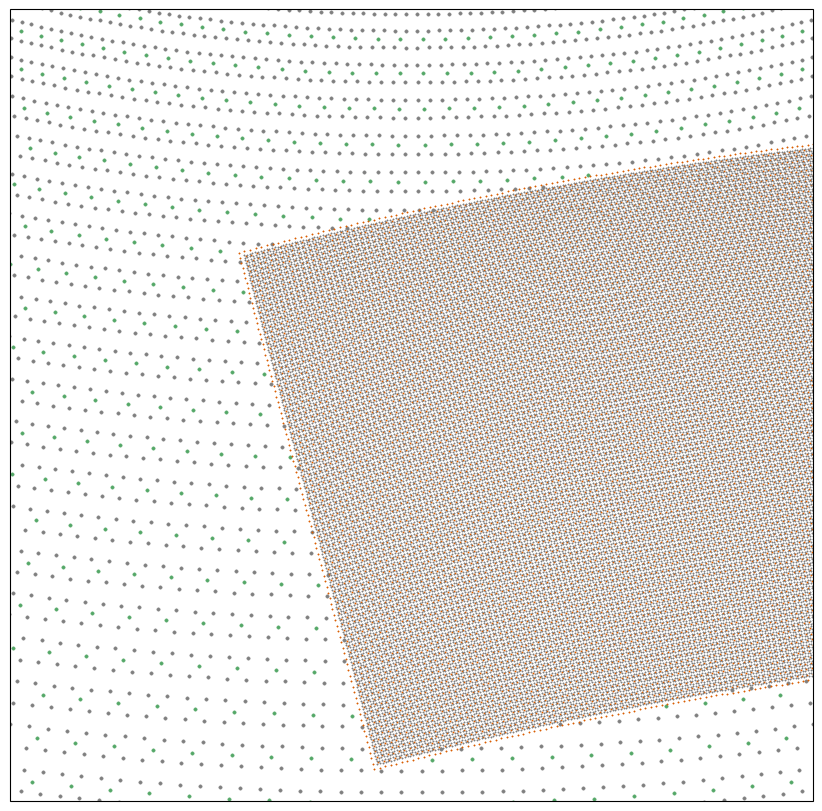

In [12]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(12,8),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for x,y, x_d, y_d, s in zip(
    [glon.flatten()[mask], hmesh.lon.values.flatten()],
    [glat.flatten()[mask], hmesh.lat.values.flatten()],
    [data.longitudes[n_cutout:], data.longitudes[:n_cutout]],
    [data.latitudes[n_cutout:], data.latitudes[:n_cutout]],
    [6, 1],
):

    kw = {"transform": ccrs.PlateCarree(), "s": s}
    ax.scatter(x,y, **kw)
    ax.scatter(x_d, y_d, color="gray", **kw)
ax.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())

anemoi-datasets cutout concatenates all LAM latitudes, then the global latitudes. Same for longitude.

...

But 

...

anemoi-graphs does it the other way around, and then sorts by lat/lon...

In [13]:
clon = np.concatenate([glon.flatten()[mask], hmesh.lon.values.flatten()])
clat = np.concatenate([glat.flatten()[mask], hmesh.lat.values.flatten()])

In [14]:
print(glon.flatten()[mask].max(), glon.flatten()[mask].min())
print(glat.flatten()[mask].max(), glat.flatten()[mask].min())

359.0 1.0
89.0 -89.0


In [15]:
print(hmesh.lon.values.max(), hmesh.lon.values.min())
print(hmesh.lat.values.max(), hmesh.lat.values.min())

296.34063128396434 228.3172081392282
51.21446932091084 22.556856739119876


In [16]:
from anemoi.graphs.generate.utils import get_coordinates_ordering
# Lets not worry about radians? since lon is 0-360 in both and -90-90 in both
#from anemoi.graphs.generate.transforms import cartesian_to_latlon_rad

In [17]:
coords = np.stack([clon, clat], axis=-1)
order = get_coordinates_ordering(coords)

In [18]:
order

array([  179,  1799, 11036, ..., 12587,  7560,     0], shape=(32414,))

In [19]:
cds = xr.Dataset(
    attrs={"n_cutout": n_cutout}
)

cds["lon"] = xr.DataArray(
    coords[order, 0],
    coords={"lon": coords[order, 0]},
)

clat = np.concatenate([glat.flatten()[mask], hmesh.lat.values.flatten()])
cds["lat"] = xr.DataArray(
    coords[order, 1],
    coords={"lat": coords[order,1]},
)

In [20]:
cds

<xarray.Dataset> Size: 519kB
Dimensions:  (lon: 32414, lat: 32414)
Coordinates:
  * lon      (lon) float64 259kB 359.0 359.0 359.0 359.0 ... 1.0 1.0 1.0 1.0
  * lat      (lat) float64 259kB -89.0 -71.0 33.0 61.0 ... 25.0 55.0 -5.0 -89.0
Data variables:
    *empty*
Attributes:
    n_cutout:  64220

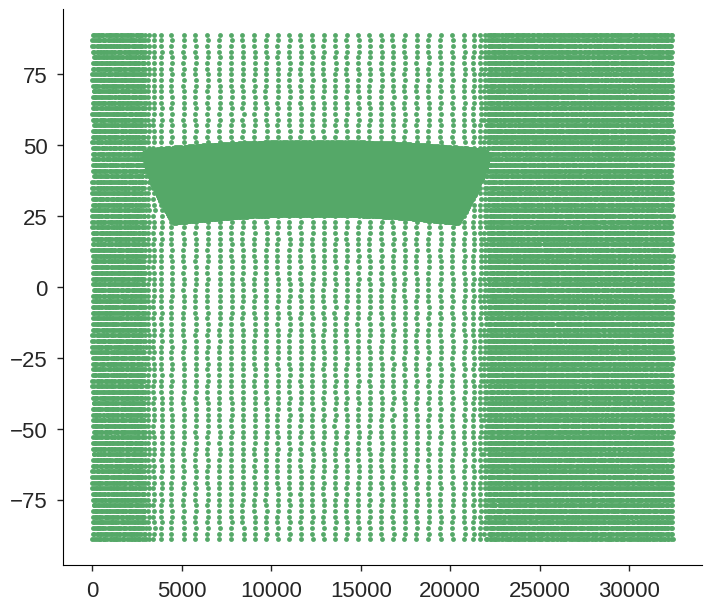

In [21]:
plt.plot(cds.lat.values, ls="", marker=".")

In [22]:
np.savez("latentx2.spongex1.combined.sorted.npz", lon=cds.lon.values, lat=cds.lat.values)

In [23]:
checkit = np.load("latentx2.spongex1.combined.sorted.npz")

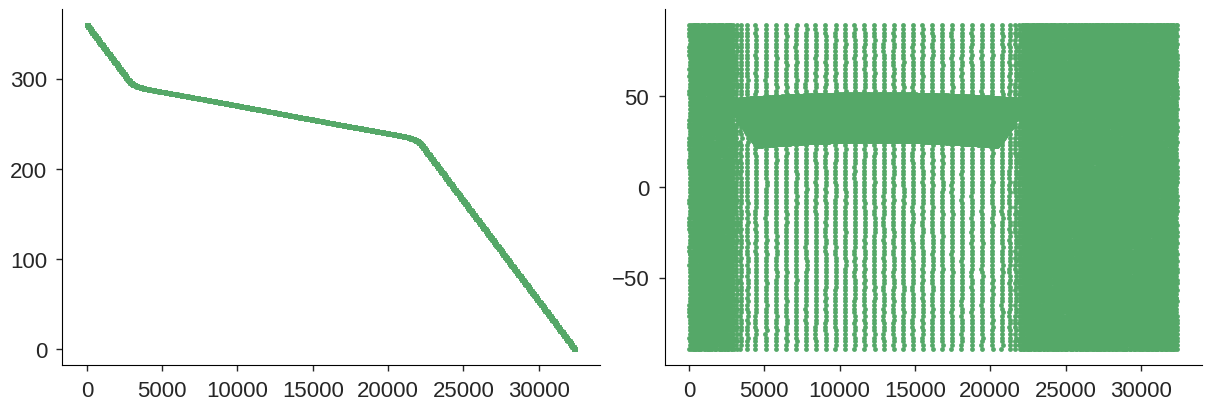

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axs[0].plot(checkit["lon"], ls="", marker=".")
axs[1].plot(checkit["lat"], ls="", marker=".")